In [29]:
# imports
import numpy as np
import copy
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import scikits.bootstrap as bootstrap
import warnings
warnings.filterwarnings('ignore') # Danger, Will Robinson! (not a scalable hack, and may surpress other helpful warning other than for ill-conditioned bootstrapped CI distributions)

import scipy.stats # for finding statistical significance

import time

from music21 import *

#make notebook wider...
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

#set up musescore support so i can show images of composition
us = environment.UserSettings()
us['musicxmlPath'] = 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe'
us['musescoreDirectPNGPath'] = 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe'
# us['musicxmlPath']

In [30]:
class Individual:
    
    def __init__(self, fitness_function, genome_length):
        #genome will be random string of numbers 0-13 (1 octave C4-C5) and 0=rest
        #genome length=16, for 4 measures/16 quarter notes
        self.genome = np.random.randint(13, size = genome_length)
        self.fitness_function = fitness_function
        self.fitness = 0
        
    def eval_fitness(self):
        self.fitness= self.fitness_function(self.genome)
    
    

In [31]:
#hamming distance calculator, sourced from https://en.wikipedia.org/wiki/Hamming_distance
#returning lower hamming distance means better match i think

def hamming_distance(string1, string2):
    dist_counter = 0
    for n in range(len(string1)):
        if string1[n] != string2[n]:
            dist_counter += 1
    return dist_counter

In [32]:
#param: measure of 4 beats
#return: score for how many musical things it satisfies
def compare_measure(measure):
    
#     print("----")
#     print(measure)
    
    popular_chords_dict = {
        "c_major": [1,5,8,13],
        "d_minor": [3,6,10],
        "e_minor": [5,8,12],
        "f_major": [6,10,1,13],
        "g_major": [8,12,3],
        "a_minor": [10,1,13,5],
        "b_diminished": [12,3,6],
        "c_major_7": [1,5,8,12],
        "d_minor_7": [3,6,10,1],
        "e_minor_7": [5,8,12,3],
        "f_major_7": [6,10,1,5],
        "g_dominate_7": [8,12,3,6],
        "a_minor_7": [10,1,5,8],
        "b_minor_7": [12,3,6,10]
    }
    
    lowest_hamming_score = 10
    potential_keys = []
    
    for key in popular_chords_dict:
        score = hamming_distance(popular_chords_dict[key], measure)
#         print(key + ": " + str(score))
        
        if score <= lowest_hamming_score:
            lowest_hamming_score = score
            potential_keys.append(key)
    
#     q = hamming_distance(popular_chords_dict["b_minor_7"], measure)
#     print(q)
#     print(lowest_hamming_score)
    
    return lowest_hamming_score, potential_keys
    
    
# measure = [10,6,3,6]
# measure2 = [1,11,7,1]
# x, y= compare_measure(measure)
# print(x,y)

# print("m2===========")
# x,y = compare_measure(measure2)
# print(x,y) 


In [33]:
#param: single measure of 4 numbers
#return: int value based on if it satisfies the pattern
def find_repetition_single_measure(measure):
#     list(measure)
    if measure[0] == measure[1] == measure[2] == measure[3]:
#         print("yea 1")
        return 1
    elif measure[0] == measure[2] and measure[1] == measure[3]:
#         print("yea 2")
        return 2
    elif measure[1] == measure[3]:
#         print("yea 3")
        return 3
    elif measure[0] == measure[2]:
#         print("yea4")
        return 4
    else:
#         print("nah")
        return 5

#determines repitition over two measures
#param: 2 measures
#return: int value based on what happens
def find_repetition_two_measures(measure_1, measure_2):
#     list(measure_1)
#     list(measure_2)
    if list(measure_1) == list(measure_2):
#         print("yea 1")
        return 1
    elif measure_1[0] == measure_1[2] == measure_2[0] == measure_2[2]:
#         print("yea 2")
        return 2
    elif measure_1[1] == measure_1[3] == measure_2[1] == measure_2[3]:
#         print("yea 3")
        return 3
    else:
        return 4

#param: takes in a single measure of 4 notes
#returns: int value based opn what happens
#checks if measure is increasing or decreasing by a certain value
#this is just a bunch of if statements... super sus, maybe i shoulda used python switch statement idk if python has those tho
def find_increasing_or_decreasing(measure):
    
    #if the whole measure is increasing or decreasing by 1 or 2
    if (measure[0]+1 == measure[1]) and (measure[1]+1 == measure[2]) and (measure[2]+1 == measure[3]):
        print("yea 6")
        return 6
    elif (measure[0]+2 == measure[1]) and (measure[1]+2 == measure[2]) and (measure[2]+2 == measure[3]):
        print("yea 7")
        return 7
    elif (measure[3]-1 == measure[2]) and (measure[2]-1 == measure[1]) and (measure[1]-1 == measure[0]):
        print("yea 8")
        return 8
    elif (measure[3]-2 == measure[2]) and (measure[2]-2 == measure[1]) and (measure[1]-2 == measure[0]):
        print("yea 9")
        return 9

    #if 3 are in sequence
    elif ((measure[0]+1 == measure[1]) and (measure[1]+1 == measure[2])) or ((measure[1]+1 == measure[2]) and (measure[2]+1 == measure[3])):
        print("yea 10")
        return 10
    elif ((measure[0]+2 == measure[1]) and (measure[1]+2 == measure[2])) or ((measure[1]+2 == measure[2]) and (measure[2]+2 == measure[3])):
        print("yea 11")
        return 11
    elif ((measure[3]-1 == measure[2]) and (measure[2]-1 == measure[1])) or ((measure[2]-1 == measure[1]) and (measure[1]-1 == measure[0])):
        print("yea 12")
        return 12
    elif ((measure[3]-2 == measure[2]) and (measure[2]-2 == measure[1])) or ((measure[2]-2 == measure[1]) and (measure[1]-2 == measure[0])):
        print("yea 13")
        return 13
    
    #if only two notes are in sequence...
    elif (measure[0]+1 == measure[1]) or (measure[1]+1 == measure[2]) or (measure[2]+1 == measure[3]):
        print("yea 1")
        return 1
    elif (measure[0]+2 == measure[1]) or (measure[1]+2 == measure[2]) or (measure[2]+2 == measure[3]):
        print("yea 2")
        return 2
    elif (measure[3]-1 == measure[2]) or (measure[2]-1 == measure[1]) or (measure[1]-1 == measure[0]):
        print("yea 3")
        return 3
    elif (measure[3]-2 == measure[2]) or (measure[2]-2 == measure[1]) or (measure[1]-2 == measure[0]):
        print("yea 4")
        return 4
    else:
        return 5
    
# m1 = [1,1,1,1]
# m4 = [0,1,0,4]
# m3 = [1,0,5,0]
# m2 = [0,1,0,1]
# m5 = [1,2,3,4]
# m6 = [1,1,1,1]
# m7 = [1,1,1,1]
# m8 = [3,1,0,1]
# m9 = [0,1,4,1]
# m10 = [1,3,1,6]
# m11 =  [1,5,1,3]

# m12 = [1,2,3,4]
# m13 = [1,3,5,7]
# m14 = [4,3,2,1]
# m15 = [7,5,3,1]

# x = find_increasing_or_decreasing(m12)
# y = find_increasing_or_decreasing(m13)
# z = find_increasing_or_decreasing(m14)
# p = find_increasing_or_decreasing(m15)

# print(x,y,z,p)

In [34]:
#calculates fitness of the genome
#param: genome (probably array of 16 numbers)
#return: fitness score, this is gonna be super arbitrary but yea...
def music_fitness(composition_bit_string):
    
    #higher total fitness scores correspond directly to higher fitness
    total_fitness_score = 0
    
    #split full composition genome into measures (4 beats)
    splits = np.array_split(composition_bit_string, len(composition_bit_string)/4)
    
    #for each measure, compare similarity to c based chords:
    for measure_splits in splits:
#         print(measure_splits)
        hamming_distance, possible_chords = compare_measure(measure_splits)
        if hamming_distance == 0:
#             print("0 hamming")
            total_fitness_score = total_fitness_score + 3
        elif hamming_distance == 1:
#             print("1 hamming")
            total_fitness_score = total_fitness_score + 2
        elif hamming_distance == 2:
#             print("2 hamming")
            total_fitness_score = total_fitness_score + 1
#     print(possible_chords)      
#     print(total_fitness_score)
    
    for measure_splits in splits:
        repitition_value = find_repetition_single_measure(measure_splits)
        
        if repitition_value == 1:
            total_fitness_score = total_fitness_score + 1
        elif repitition_value ==2:
            total_fitness_score = total_fitness_score + 3
        elif repitition_value ==3:
            total_fitness_score = total_fitness_score + 2
        elif repitition_value ==4:
            total_fitness_score = total_fitness_score + 2
            
            
#     print(total_fitness_score)      
    for i in range(len(measure_splits)):
        for j in range(len(measure_splits)):
            if i != j:
                rep_2_measure_score = find_repetition_two_measures(splits[i], splits[j])
                if rep_2_measure_score == 1:
                    total_fitness_score = total_fitness_score + 3
                elif rep_2_measure_score == 2 or rep_2_measure_score == 3:
                    total_fitness_score = total_fitness_score + 2
                
                
#     print(total_fitness_score)
    return total_fitness_score        
                
# composition_genome = [1, 1, 2, 3, 1, 5,6,7,2,6,7,5,2,3,4,5]
comp_2 = np.random.randint(13, size = 16)
# comp_3= np.random.randint(13, size = 16)
# print(comp_2)
# print(comp_3)
# x =music_fitness(composition_genome)
# print("==" + str(x))

y =music_fitness(comp_2)
# print("==" + str(y))

# z =music_fitness(comp_3)
# print("==" + str(z))

In [35]:

#determines what the new note value will be at that index of the genome
#param: this_child[element] (int)
#returns: new value for element (int)
def mutate_genome(note_value):
    #if note is a rest, randomly select a new note
    if note_value == 0:
        note_value = np.random.choice([1,2,3,4,5,6,7,8,9,10,11,12,13])
        
    #if note is an actual note, mutate it based on random chance
    else:
        chance = np.random.randint(99)
        if chance <= 60:
            note_value = note_value + np.random.choice([-1,1])
        
        elif chance > 60 and chance <= 85:
            note_value = note_value + np.random.choice([-2,2])
        
        else:
            note_value = 0
    
    #if the note_value becomes an unnamed note, randomly change it to a real note. bandaid fix idk how i would fix this...
    if note_value < 0 or note_value > 13:
        note_value = np.random.choice([1,2,3,4,5,6,7,8,9,10,11,12,13])
    
    return note_value

In [36]:
def convert_population_to_composition(population_at_i_generation):
    note_dict = {
        0: note.Rest(),
        1: note.Note("C4"),
        2: note.Note("C#4"),
        3: note.Note("D4"),
        4: note.Note("D#4"),
        5: note.Note("E4"),
        6: note.Note("F4"),
        7: note.Note("F#4"),
        8: note.Note("G4"),
        9: note.Note("G#4"),
        10: note.Note("A4"),
        11: note.Note("A#4"),
        12: note.Note("B4"),
        13: note.Note("C5")
    }
    
    genome_number = 1
    for genome in population_at_i_generation:
        genome_stream = stream.Stream()
        for gene in genome:
            note1 = copy.deepcopy(note_dict[gene])
            genome_stream.append(note1)
            
            
        print("=============================================================================")
        print("Genome Number: " + str(genome_number))
        print("Genome String: " + str(genome))
        genome_stream.show()
        genome_stream.show('midi')
        print("=============================================================================")
        genome_number = genome_number + 1
# test_pop = []
# for i in range(10):
#     test_pop.append(np.random.randint(13, size = 16))

# convert_population_to_composition(test_pop)   


In [37]:

def turn_user_input_into_array(user_input):
    x = user_input.split(",")
    y = np.asarray(x, int)
    return y
    
    
# values = "1,4,6,7"
# turn_user_input_into_array(values)

In [38]:

def evolutionary_algorithm(fitness_function=None, total_generations=100, num_parents=10, num_children=10, genome_length=16, num_elements_to_mutate=1, mutation_size=0.1, crossover=True, tournament_size=4, num_tournament_winners=2, include_interactive_evolution=True, interactively_evolve_every_X=10):

    # initialize record keeping
    solution = None # best genome so far
    solution_fitness = -99999 # fitness of best genome so far
    best_accuracy = -99999 # fitness of best genome so far
    fitness_over_time = np.zeros(total_generations)
    solutions_over_time = np.zeros((total_generations,genome_length))
    diversity_over_time = np.zeros(total_generations)
    
    worst_fitness_individual = []
    worst_fitness = 0
    # the initialization proceedure
    population = [] # keep population of individuals in a list
    for i in range(num_parents): # only create parents for initialization (the mu in mu+lambda)
        population.append(Individual(fitness_function,genome_length)) # generate new random individuals as parents
    
    # get population fitness
    for i in range(len(population)):
        population[i].eval_fitness() # evaluate the fitness of each parent
        if population[i].fitness > worst_fitness:
            worst_fitness = population[i].fitness
            worst_fitness_individual = population[i].genome
            
    for generation_num in range(total_generations): # repeat
        
        # the modification procedure
        new_children = [] # keep children separate for now (lambda in mu+lambda)
        while len(new_children) < num_children:
            
            # inheretance
            [parent1, parent2] = np.random.choice(population, size=2) # pick 2 random parents
            child1 = copy.deepcopy(parent1) # initialize children as perfect copies of their parents
            child2 = copy.deepcopy(parent2)
            
            # crossover
            # N/A
            # mutation
            for this_child in [child1,child2]:
                elements_to_mutate = set()
                while len(elements_to_mutate)<num_elements_to_mutate:
                    elements_to_mutate.add(np.random.randint(genome_length)) # randomly select the location in the child bit string to mutate
                for this_element_to_mutate in elements_to_mutate:
                    this_child.genome[this_element_to_mutate] = mutate_genome(this_child.genome[this_element_to_mutate]) # mutate based on mutation function
        
            new_children.extend((child1,child2)) # add children to the new_children list
            

        # the assessement procedure
        for i in range(len(new_children)):
            new_children[i].eval_fitness() # assign fitness to each child 
            
            
        # selection procedure
        population += new_children # combine parents with new children (the + in mu+lambda)
        

#==========================
        #determine which music the user likes, adds certain amount to fitness
        if include_interactive_evolution:
            if generation_num % interactively_evolve_every_X == 0:
                
                print("Generation: " + str(generation_num))
                print("Population Length: " + str(len(population)))
                population_at_j_genome_array = []
                for j in range(len(population)):
                    population_at_j_genome_array.append(population[j].genome)
                
                
                
                convert_population_to_composition(population_at_j_genome_array)

                user_input = input("Which compositions did you like? ei- 1,4,6,8,10 : ")
                
                liked_compositions = turn_user_input_into_array(user_input)
                
                for liked in liked_compositions:
                    population[liked].fitness = population[liked].fitness + 5

#=========================
        population = sorted(population, key=lambda individual: individual.fitness, reverse = True) # sort the full population by each individual's fitness (from highers to lowest)
        
        # tournament selection
        new_population = []
        new_population.append(population[0])
        while len(new_population) < num_parents:
            tournament = np.random.choice(population, size = tournament_size)
            tournament = sorted(tournament, key=lambda individual: individual.fitness, reverse = True)
            new_population.extend(tournament[:num_tournament_winners])    
        population = new_population
        
        # record keeping
        
        if population[0].fitness > solution_fitness: # if the new parent is the best found so far
            solution = population[0].genome                 # update best solution records
            solution_fitness = population[0].fitness
            solution_generation = generation_num
        fitness_over_time[generation_num] = solution_fitness # record the fitness of the current best over evolutionary time
        solutions_over_time[generation_num,:] = solution
        
        genome_list = np.array([individual.genome for individual in population])
        diversity = np.mean(genome_list.std(axis=0))
        diversity_over_time[generation_num] = diversity
                
#         print(generation_num, solution_fitness, best_accuracy, diversity)
        
    return fitness_over_time, solutions_over_time, diversity_over_time, worst_fitness_individual
    
    
# fitness_over_time, solutions_over_time, diversity_over_time = evolutionary_algorithm(fitness_function=np.sum, total_generations=20, 
#                                                                                      num_parents=10, num_children=10, genome_length=16, 
#                                                                                      num_elements_to_mutate=1, mutation_size=0.1, crossover=True, 
#                                                                                      tournament_size=4, num_tournament_winners=2)


# print(solutions_over_time)
# print(sum(solutions_over_time[1]))
# print(sum(solutions_over_time[10]))
# print(fitness_over_time)


In [39]:
def plot_mean_and_bootstrapped_ci_over_time(input_data = None, name = "change me", x_label = "change me", y_label="change me", y_limit = None, plot_bootstrap = True):
    """
    
    parameters: 
    input_data: (numpy array of shape (max_k, num_repitions)) solution metric to plot
    name: (string) name for legend
    x_label: (string) x axis label
    y_label: (string) y axis label
    
    returns:
    None
    """

    fig, ax = plt.subplots() # generate figure and axes

    if isinstance(name, str): name = [name]; input_data = [input_data]

    # for this_input_data, this_name in zip(input_data, name):
    for this_name in name:
        print("plotting",this_name)
        this_input_data = input_data[this_name]
        total_generations = this_input_data.shape[1]

        if plot_bootstrap:
            boostrap_ci_generation_found = np.zeros((2,total_generations))
            for this_gen in range(total_generations):
                if this_gen%10==0: print(this_gen)
                boostrap_ci_generation_found[:,this_gen] = bootstrap.ci(this_input_data[:,this_gen], np.mean, alpha=0.05)


        ax.plot(np.arange(total_generations), np.mean(this_input_data,axis=0), label = this_name) # plot the fitness over time
        if plot_bootstrap:
            ax.fill_between(np.arange(total_generations), boostrap_ci_generation_found[0,:], boostrap_ci_generation_found[1,:],alpha=0.3) # plot, and fill, the confidence interval for fitness over time
        ax.set_xlabel(x_label) # add axes labels
        ax.set_ylabel(y_label)
        if y_limit: ax.set_ylim(y_limit[0],y_limit[1])
        plt.legend(loc='best'); # add legend

In [43]:
experiment_results = {}
solutions_results = {}
diversity_results = {}
worst_fitness_individual = {}


num_runs = 10
total_generations = 100
num_elements_to_mutate = 1
genome_length = 16
num_parents = 50
num_children = 50
interactively_evolve_every_X = 20

for run_name in ["evolution_without_interactive_element"]:
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions_results[run_name] = np.zeros((num_runs, total_generations, genome_length))
    diversity_results[run_name] = np.zeros((num_runs, total_generations))
    for run_num in range(num_runs):       
        start_time = time.time()
        fitness_over_time, solutions_over_time, diversity_over_time, worst_fitness_individual = evolutionary_algorithm(fitness_function=music_fitness, total_generations=total_generations, 
                                                                                             num_parents=num_parents, num_children=num_children, genome_length=16, 
                                                                                             num_elements_to_mutate=1, mutation_size=0.1, crossover=True, 
                                                                                             tournament_size=4, num_tournament_winners=2, include_interactive_evolution=False,
                                                                                             interactively_evolve_every_X = interactively_evolve_every_X)

        experiment_results[run_name][run_num] = fitness_over_time
        solutions_results[run_name][run_num] = solutions_over_time
        diversity_results[run_name][run_num] = diversity_over_time
    
        
# for run_name in ["evolution_with_interactive_element"]:
#     experiment_results[run_name] = np.zeros((num_runs, total_generations))
#     solutions_results[run_name] = np.zeros((num_runs, total_generations, genome_length))
#     diversity_results[run_name] = np.zeros((num_runs, total_generations))
#     for run_num in range(num_runs):       
#         start_time = time.time()
#         fitness_over_time, solutions_over_time, diversity_over_time, worst_fitness_individual = evolutionary_algorithm(fitness_function=music_fitness, total_generations=total_generations, 
#                                                                                              num_parents=num_parents, num_children=num_children, genome_length=16, 
#                                                                                              num_elements_to_mutate=1, mutation_size=0.1, crossover=True, 
#                                                                                              tournament_size=4, num_tournament_winners=2, include_interactive_evolution=True,
#                                                                                              interactively_evolve_every_X = interactively_evolve_every_X)

#         experiment_results[run_name][run_num] = fitness_over_time
#         solutions_results[run_name][run_num] = solutions_over_time
#         diversity_results[run_name][run_num] = diversity_over_time
    
        
        
        
        
        
        
        
        
        
        
        
        
        
        

plotting evolution_without_interactive_element
0
10
20
30
40
50
60
70
80
90
plotting evolution_without_interactive_element
0
10
20
30
40
50
60
70
80
90


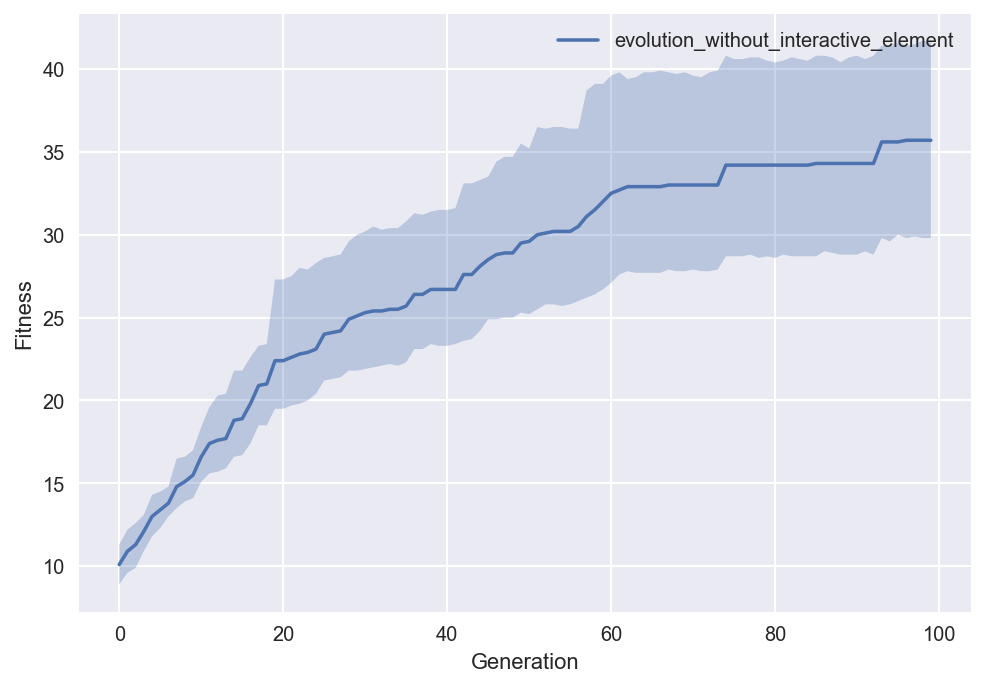

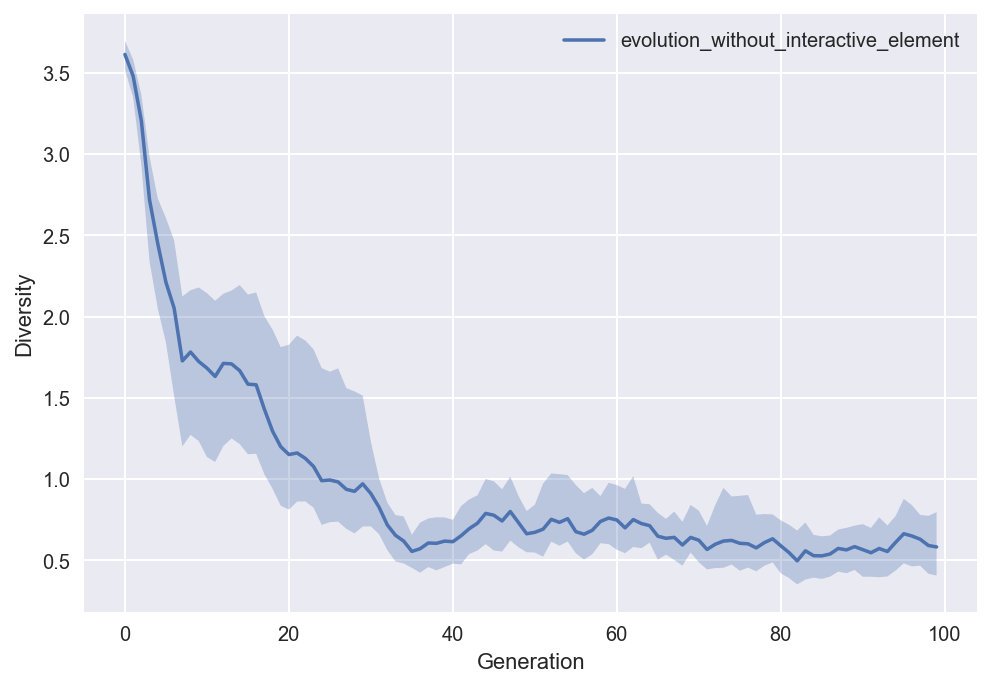

In [44]:
plot_mean_and_bootstrapped_ci_over_time(input_data = experiment_results, name = ["evolution_without_interactive_element"], x_label = "Generation", y_label = "Fitness", plot_bootstrap = True)
plot_mean_and_bootstrapped_ci_over_time(input_data = diversity_results, name = ["evolution_without_interactive_element"], x_label = "Generation", y_label = "Diversity", plot_bootstrap = True)
# print(experiment_results)

Final Evolution, Best Solution


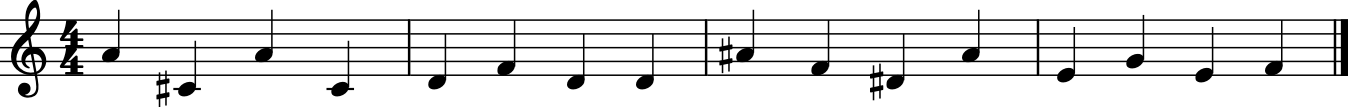

Worst Solution


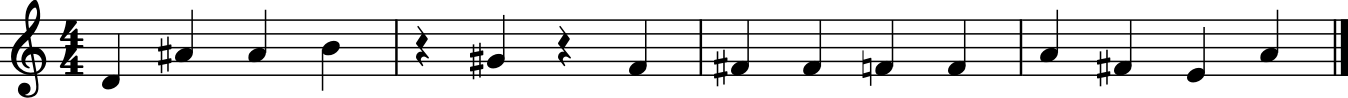

In [277]:
# print(fitness_over_time)
# print(solutions_over_time)
# print(solutions_over_time[0])
# print(solutions_over_time[10])
# print(solutions_over_time[99])

int_array_worse = solutions_over_time[0].tolist()
int_array = solutions_over_time[50].tolist()
# print(int_array)

stream6 = stream.Stream()
stream7 = stream.Stream()
for t in int_array:
    n = copy.deepcopy(note_dict[t])
    stream6.append(n)


for t in int_array_worse:
    n = copy.deepcopy(note_dict[t])
    stream7.append(n)  
    
    
print("Final Evolution, Best Solution")
stream6.show()
print("Worst Solution")
stream7.show()
# stream6.show('midi')

<music21.note.Rest quarter>
<music21.note.Note C>
<music21.note.Note C#>
<music21.note.Note D>
<music21.note.Note D#>
<music21.note.Note E>
<music21.note.Note F>
<music21.note.Note F#>
<music21.note.Note G>
<music21.note.Note G#>
<music21.note.Note A>
<music21.note.Note A#>
<music21.note.Note B>
<music21.note.Note C>

A Chromatic Scale starting at C4


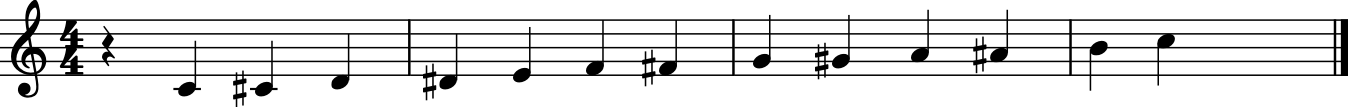


----------------------------------------------------------------------------
An example of a randomly generated initial parent
[ 5  9  3  2 11  6  4  0 12  2 12  8  9 11 10  0]


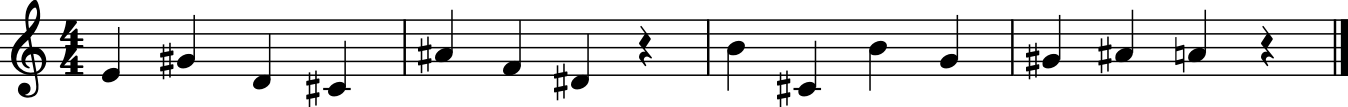

----------------------------------------------------------------------------


In [28]:
#audio testing

note_dict = {
    0: note.Rest(),
    1: note.Note("C4"),
    2: note.Note("C#4"),
    3: note.Note("D4"),
    4: note.Note("D#4"),
    5: note.Note("E4"),
    6: note.Note("F4"),
    7: note.Note("F#4"),
    8: note.Note("G4"),
    9: note.Note("G#4"),
    10: note.Note("A4"),
    11: note.Note("A#4"),
    12: note.Note("B4"),
    13: note.Note("C5")
}

stream1 = stream.Stream()


for key in note_dict:
    note1 = copy.deepcopy(note_dict[key])
    print(note1)
    stream1.append(note1)
    
print()
print("A Chromatic Scale starting at C4")
stream1.show()
print()


# print(type(key))
# for thisNote in stream1:
#     print(thisNote.name)

# stream1.show()
# stream1.show('midi')
print("----------------------------------------------------------------------------")
stream2 = stream.Stream()
x = np.random.randint(13, size = 16)

# for gene in x:
#     note2 = copy.deepcopy(note_dict[gene])
#     print(note2)
#     stream2.append(note2)

note2 = copy.deepcopy(note_dict[10])
note3 = copy.deepcopy(note_dict[6])
note4 = copy.deepcopy(note_dict[3])
note5 = copy.deepcopy(note_dict[6])

stream2.append(note2)
stream2.append(note3)
stream2.append(note4)
stream2.append(note5)


stream3 = stream.Stream()
x = np.random.randint(13, size = 4)

for gene in x:
    note2 = copy.deepcopy(note_dict[gene])
    stream3.append(note2)

stream4 = stream.Stream()
geneome1 = [1, 1, 2, 3, 1, 5,6,7,2,6,7,5,2,3,4,5]

for t in geneome1:
    n = copy.deepcopy(note_dict[t])
    stream4.append(n)
    

genome5 = [ 0,  6,  0,  6,  6,  3,  6,  3,  5,  8, 12,  8,  3,  1,  3,  1]
genome5_start = [ 0, 12,  0, 10,  5,  4,  5,  4,  1,  0, 11,  7,  3,  1,  3, 11]

stream5 = stream.Stream()
stream5start = stream.Stream()
for t in genome5:
    n = copy.deepcopy(note_dict[t])
    stream5.append(n)
    

newgenome = np.random.randint(13, size = 16)
    
    
for t in newgenome:
    n = copy.deepcopy(note_dict[t])
    stream5start.append(n)
    
    
    
print("An example of a randomly generated initial parent")
print(newgenome)
stream5start.show()
# stream5start.show('midi')

print("----------------------------------------------------------------------------")
# print("gen 0")
# stream5start.show()
# stream5start.show('midi')

biggie cheese


What is your name: buhr
buhr
What is your name: xd
xd
What is your name: meme
meme


In [139]:
# listA = [1, 1, 2, 3, 1, 5,6,7,2,6,7,5,2,3,4,5]

# splits = np.array_split(listA, len(listA)/4)

# for array in splits:
#     print(list(array))

In [62]:
a_list = [m4,m2,m4,m3]


m1 = [1,1,1,1]
m4 = [0,1,0,4]
m3 = [1,0,5,0]
m2 = [0,1,0,1]

for i in range(len(a_list)):
    for j in range(len(a_list)):
        if i != j:
            print(find_repetition_two_measures(a_list[i], a_list[j]))
            #compare a_list[i] to a_list[j]
    
    
    
    


2
1
4
2
2
4
1
2
4
4
4
4
